# Rental Property ROI Analysis in London

This notebook analyzes potential returns on investment for residential properties in London Zones 1 and 2, considering:
- Multiple rental yield scenarios
- Different property appreciation rates
- Various LTV ratios and interest rates
- Cash ROI vs Total ROI (including equity buildup)

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.mortgage_calculator import MortgageCalculator
from src.rental_analysis import RentalAnalyzer

plt.style.use('seaborn-v0_8-whitegrid') # to view seaborn styles: [x for x in plt.style.available if 'seaborn' in x]
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Initialize analyzers
mortgage_calc = MortgageCalculator()
rental_analyzer = RentalAnalyzer()

# Define analysis parameters
property_values = np.array([500000, 750000, 1000000])
zones = ['Zone 1', 'Zone 2']
analysis_period = 5  # years

## Cash ROI Analysis
First, let's analyze the cash returns across different scenarios

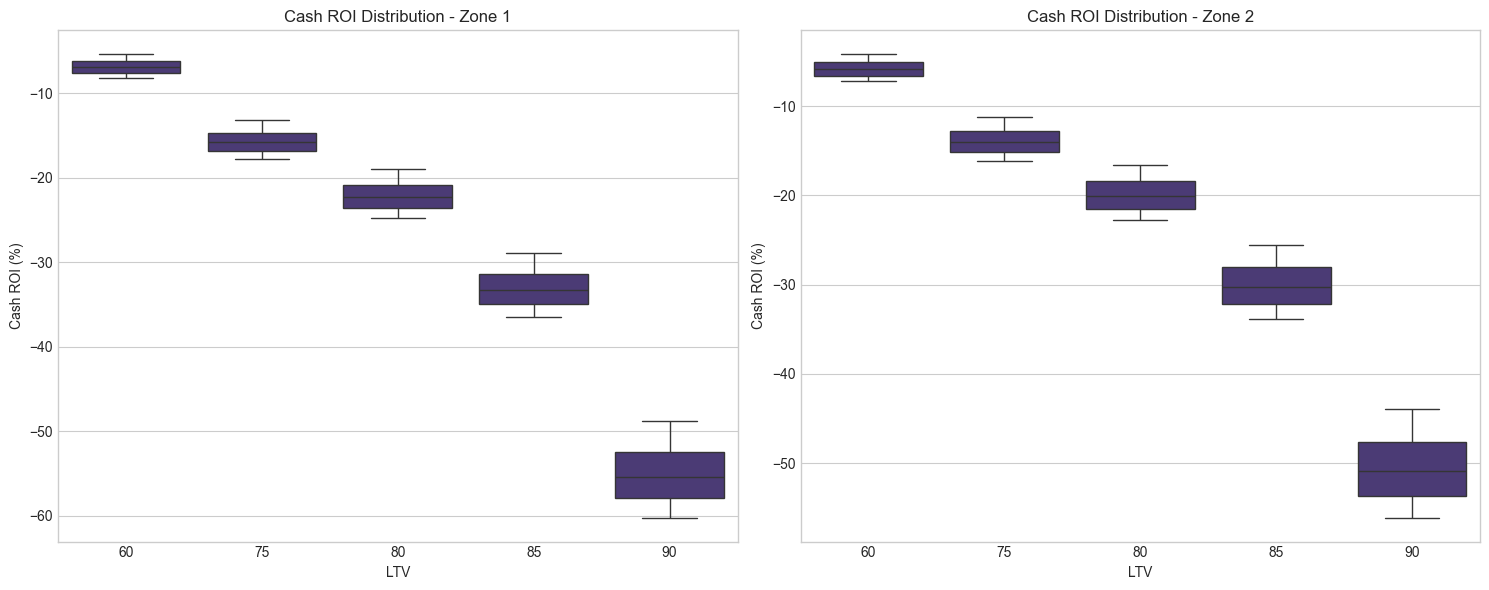

In [3]:
def analyze_cash_returns(property_value, zone, ltv):
    deposit = property_value * (1 - ltv/100)
    loan_amount = property_value - deposit
    rate = mortgage_calc.get_rate_for_ltv(ltv)[0]  # Using minimum rate for conservative estimate
    
    monthly_payment = mortgage_calc.calculate_monthly_payment(loan_amount, rate, 25)
    return rental_analyzer.calculate_cash_roi(property_value, deposit, monthly_payment, zone)

# Analyze cash returns for a £500k property in both zones
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, zone in enumerate(zones):
    ltv_results = []
    for ltv in [60, 75, 80, 85, 90]:
        results = analyze_cash_returns(500000, zone, ltv)
        results['LTV'] = ltv
        ltv_results.append(results)
    
    df = pd.concat(ltv_results)
    sns.boxplot(data=df, x='LTV', y='Cash ROI', ax=axes[idx])
    axes[idx].set_title(f'Cash ROI Distribution - {zone}')
    axes[idx].set_ylabel('Cash ROI (%)')

plt.tight_layout()
plt.show()

## Total ROI Analysis
Now let's analyze total returns including property appreciation and equity buildup

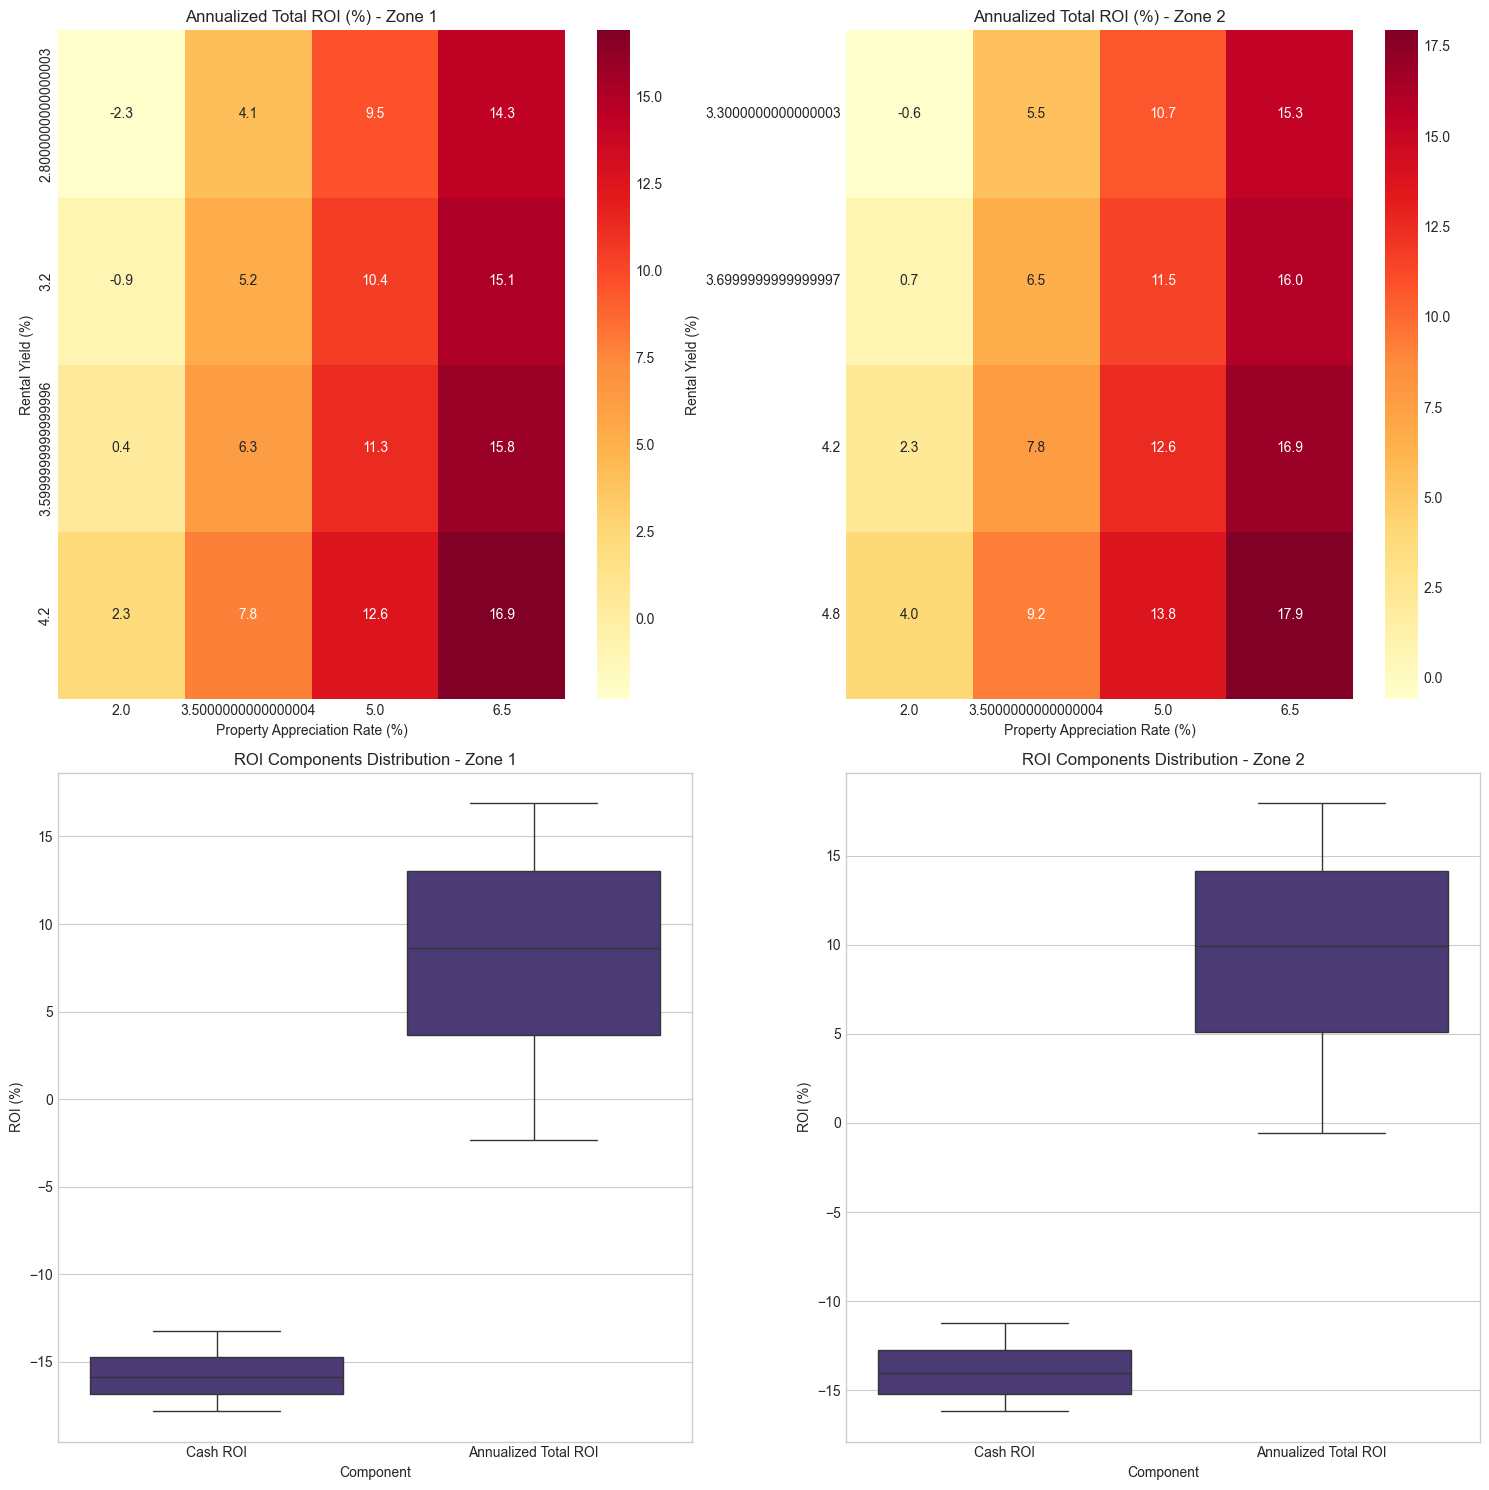

In [4]:
def analyze_total_returns(property_value, zone, ltv):
    deposit = property_value * (1 - ltv/100)
    loan_amount = property_value - deposit
    rate = mortgage_calc.get_rate_for_ltv(ltv)[0]  # Using minimum rate
    
    return rental_analyzer.calculate_total_roi(
        property_value, deposit, loan_amount, rate, 25, zone, analysis_period)

# Create heatmaps showing ROI components for different scenarios
property_value = 500000
ltv = 75  # Example LTV

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for zone_idx, zone in enumerate(zones):
    results = analyze_total_returns(property_value, zone, ltv)
    
    # Reshape data for heatmap
    pivot_data = results.pivot_table(
        values='Annualized Total ROI',
        index='Rental Yield',
        columns='Appreciation Rate'
    )
    
    # Plot heatmap
    sns.heatmap(pivot_data, ax=axes[zone_idx], annot=True, fmt='.1f', cmap='YlOrRd')
    axes[zone_idx].set_title(f'Annualized Total ROI (%) - {zone}')
    axes[zone_idx].set_xlabel('Property Appreciation Rate (%)')
    axes[zone_idx].set_ylabel('Rental Yield (%)')
    
    # Plot ROI components
    components = results[['Cash ROI', 'Appreciation Rate', 'Annualized Total ROI']].melt(
        id_vars=['Appreciation Rate'],
        var_name='Component',
        value_name='ROI'
    )
    
    sns.boxplot(data=components, x='Component', y='ROI', ax=axes[zone_idx + 2])
    axes[zone_idx + 2].set_title(f'ROI Components Distribution - {zone}')
    axes[zone_idx + 2].set_ylabel('ROI (%)')

plt.tight_layout()
plt.show()

## Investment Summary
Let's create a summary of the best performing scenarios

In [5]:
# Aggregate results for different property values
summary_results = []

for value in property_values:
    for zone in zones:
        results = analyze_total_returns(value, zone, 75)  # Using 75% LTV as baseline
        results['Property Value'] = value
        results['Zone'] = zone
        summary_results.append(results)

summary_df = pd.concat(summary_results)

# Display top performing scenarios
print("Top 10 Scenarios by Total ROI:")
top_scenarios = summary_df.nlargest(10, 'Annualized Total ROI')[
    ['Property Value', 'Zone', 'Rental Yield', 'Appreciation Rate', 
     'Cash ROI', 'Annualized Total ROI']
].round(2)

display(top_scenarios)

# Calculate risk metrics
risk_metrics = summary_df.groupby(['Zone', 'Property Value'])[
    ['Cash ROI', 'Annualized Total ROI']
].agg(['mean', 'std']).round(2)

print("\nRisk Metrics by Zone and Property Value:")
display(risk_metrics)

Top 10 Scenarios by Total ROI:


,Property Value,Zone,Rental Yield,Appreciation Rate,Cash ROI,Annualized Total ROI
15,750000,Zone 2,4.8,6.5,-11.25,17.93
15,500000,Zone 2,4.8,6.5,-11.25,17.93
15,1000000,Zone 2,4.8,6.5,-11.25,17.93
15,500000,Zone 1,4.2,6.5,-13.22,16.89
11,500000,Zone 2,4.2,6.5,-13.22,16.89
15,750000,Zone 1,4.2,6.5,-13.22,16.89
11,750000,Zone 2,4.2,6.5,-13.22,16.89
15,1000000,Zone 1,4.2,6.5,-13.22,16.89
11,1000000,Zone 2,4.2,6.5,-13.22,16.89
7,500000,Zone 2,3.7,6.5,-14.86,16.00



Risk Metrics by Zone and Property Value:


Cash ROI       Annualized Total ROI      
                          mean   std                 mean   std
Zone   Property Value                                          
Zone 1 500000           -15.68  1.75                 8.05  6.18
       750000           -15.68  1.75                 8.05  6.18
       1000000          -15.68  1.75                 8.05  6.18
Zone 2 500000           -13.87  1.90                 9.37  5.91
       750000           -13.87  1.90                 9.37  5.91
       1000000          -13.87  1.90                 9.37  5.91